C:\Users\wtupw\anaconda3\envs\SlideTutor-1.5B\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1: 100%|██████████| 565/565 [04:23<00:00,  2.15it/s, loss=2e+4]   


Epoch 1 - Dev: Precision: 0.5649, Recall: 0.4950, F1: 0.4970


Epoch 2: 100%|██████████| 565/565 [04:07<00:00,  2.29it/s, loss=2e+4]   


Epoch 2 - Dev: Precision: 0.5991, Recall: 0.5255, F1: 0.5334


Epoch 3: 100%|██████████| 565/565 [04:00<00:00,  2.35it/s, loss=1.99e+4]


Epoch 3 - Dev: Precision: 0.6184, Recall: 0.5325, F1: 0.5393


Epoch 4: 100%|██████████| 565/565 [03:57<00:00,  2.38it/s, loss=1.99e+4]


Epoch 4 - Dev: Precision: 0.6339, Recall: 0.5485, F1: 0.5595


Epoch 5: 100%|██████████| 565/565 [03:59<00:00,  2.35it/s, loss=1.99e+4]


Epoch 5 - Dev: Precision: 0.6310, Recall: 0.5597, F1: 0.5712


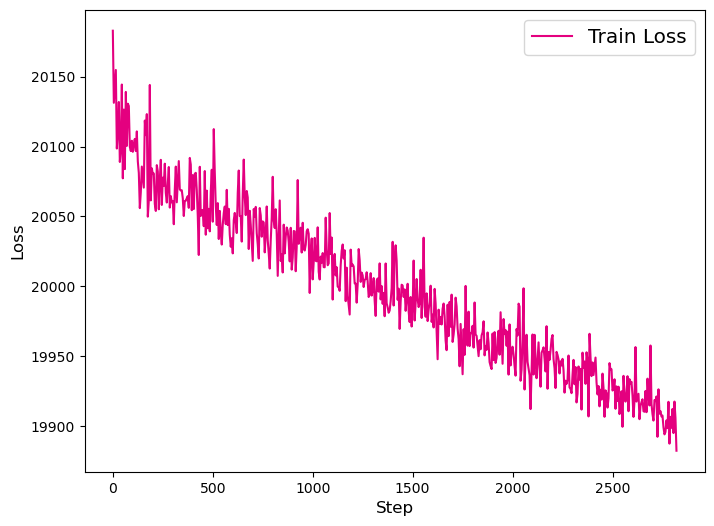

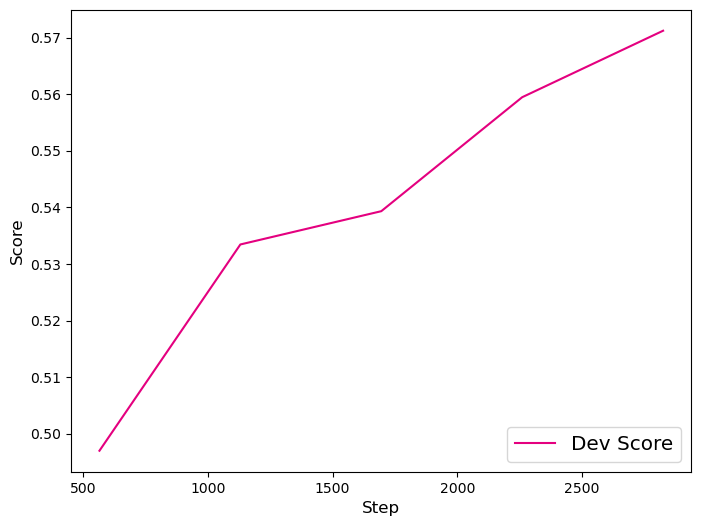

Test Results - Precision: 0.6243, Recall: 0.5659, F1: 0.5777


In [4]:
import json
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch
from transformers import BertTokenizer
import math

class WordSegmentationDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=512):
        self.data = []
        self.label2id = {"O": 0, "B": 1, "M": 2, "E": 3, "S": 4}
        self.tokenizer = tokenizer
        self.max_length = max_length

        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                item = json.loads(line)
                self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = item["text"].split(" ")
        labels = item["label"].split(" ")

        # Tokenize text and align labels
        input_ids = []
        label_ids = []

        for word, tag in zip(text, labels):
            word_tokens = self.tokenizer.tokenize(word)
            input_ids.extend(self.tokenizer.convert_tokens_to_ids(word_tokens))

            # Handle labels for subword tokens
            if len(word_tokens) > 1:
                label_ids.append(self.label2id[tag])
                label_ids.extend([self.label2id["M"]] * (len(word_tokens) - 1))
            else:
                label_ids.append(self.label2id[tag])

        # Truncate if exceeds max length
        if len(input_ids) > self.max_length - 2:  # Account for [CLS] and [SEP]
            input_ids = input_ids[:self.max_length - 2]
            label_ids = label_ids[:self.max_length - 2]

        # Add special tokens
        input_ids = [self.tokenizer.cls_token_id] + input_ids + [self.tokenizer.sep_token_id]
        label_ids = [self.label2id["O"]] + label_ids + [self.label2id["O"]]

        # Create attention mask
        attention_mask = [1] * len(input_ids)

        # Padding
        padding_length = self.max_length - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + [self.tokenizer.pad_token_id] * padding_length
            attention_mask = attention_mask + [0] * padding_length
            label_ids = label_ids + [self.label2id["O"]] * padding_length

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(label_ids, dtype=torch.long)
        }


# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

# Create datasets
train_dataset = WordSegmentationDataset("data/data174918/train.json", tokenizer)
dev_dataset = WordSegmentationDataset("data/data174918/dev.json", tokenizer)
test_dataset = WordSegmentationDataset("data/data174918/test.json", tokenizer)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class TransformerCRF(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, num_layers=4, num_heads=8,
                 hidden_dim=1024, num_labels=5, dropout=0.1):
        super(TransformerCRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)

        encoder_layers = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, num_labels)


        self.transitions = nn.Parameter(torch.empty(num_labels, num_labels))
        nn.init.xavier_normal_(self.transitions)
        self.transitions.data[0, :] = -10000  # Never transition to padding
        self.transitions.data[:, 0] = -10000  # Never transition from padding


        self.num_labels = num_labels
        self.embed_dim = embed_dim

    def forward(self, input_ids, attention_mask, labels=None):
        # Embedding
        embeddings = self.embedding(input_ids) * torch.sqrt(torch.tensor(self.embed_dim, dtype=torch.float32))
        embeddings = self.pos_encoder(embeddings)

        # Transformer
        # Need to transpose for transformer (seq_len, batch_size, embed_dim)
        embeddings = embeddings.transpose(0, 1)
        transformer_output = self.transformer(embeddings, src_key_padding_mask=~attention_mask.bool())
        transformer_output = transformer_output.transpose(0, 1)

        # Linear layer
        emissions = self.fc(transformer_output)



        if labels is not None:
            loss = -self.crf_log_likelihood(emissions, labels, attention_mask)
            # Return the mean loss across the batch
            return loss.mean()
        else:
            return self.viterbi_decode(emissions, attention_mask)

    def crf_log_likelihood(self, emissions, tags, mask):
        batch_size, seq_len, num_tags = emissions.shape
        assert num_tags == self.num_labels

        # Add emission scores
        score = emissions.gather(2, tags.unsqueeze(-1)).squeeze(-1)

        # Add transition scores between consecutive tags
        trans_score = self.transitions[tags[:, :-1], tags[:, 1:]]
        score[:, 1:] += trans_score * mask[:, 1:]

        # Sum over sequence
        total_score = (score * mask).sum(dim=1)

        # Compute partition function (logZ)
        logZ = self.compute_log_partition(emissions, mask)

        return total_score - logZ

    def compute_log_partition(self, emissions, mask):
        batch_size, seq_len, num_tags = emissions.shape
        mask = mask.float()
        alpha = emissions[:, 0]  # (batch_size, num_tags)

        for t in range(1, seq_len):
            # Broadcast alpha and transitions
            alpha_expanded = alpha.unsqueeze(2)
            trans_expanded = self.transitions.unsqueeze(0)

            # Compute next alpha (avoid inplace operations)
            next_alpha = torch.logsumexp(alpha_expanded + trans_expanded, dim=1)
            next_alpha = next_alpha + emissions[:, t]


            mask_t = mask[:, t].unsqueeze(1)
            alpha = torch.where(mask_t.bool(), next_alpha, alpha)


        logZ = torch.logsumexp(alpha, dim=1)  #
        return logZ

    def viterbi_decode(self, emissions, mask):
        batch_size, seq_len, num_tags = emissions.shape
        mask = mask.float()


        viterbi = torch.zeros(batch_size, seq_len, num_tags).to(emissions.device)
        backpointers = torch.zeros(batch_size, seq_len, num_tags, dtype=torch.long).to(emissions.device)


        viterbi[:, 0] = emissions[:, 0]

        for t in range(1, seq_len):
            viterbi_expanded = viterbi[:, t - 1].unsqueeze(2)
            trans_expanded = self.transitions.unsqueeze(0)


            scores = viterbi_expanded + trans_expanded
            max_scores, max_indices = torch.max(scores, dim=1)


            viterbi[:, t] = max_scores + emissions[:, t]
            backpointers[:, t] = max_indices


            mask_t = mask[:, t].unsqueeze(1)
            viterbi[:, t] = mask_t * viterbi[:, t] + (1 - mask_t) * viterbi[:, t - 1]

        best_paths = []
        max_final_scores, best_final_tags = torch.max(viterbi[:, -1], dim=1)

        for i in range(batch_size):
            best_path = [best_final_tags[i].item()]

            for t in range(seq_len - 1, 0, -1):
                best_tag = backpointers[i, t, best_path[-1]]
                best_path.append(best_tag.item())

            best_path.reverse()
            best_paths.append(best_path)

        return torch.tensor(best_paths).to(emissions.device)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


import torch.optim as optim
from tqdm import tqdm
import math
from sklearn.metrics import precision_score, recall_score, f1_score


def calculate_metrics(true_labels, pred_labels):
    # Filter out padding labels (0)
    filtered_true = []
    filtered_pred = []

    for t, p in zip(true_labels, pred_labels):
        if t != 0:  # Skip padding
            filtered_true.append(t)
            filtered_pred.append(p)

    precision = precision_score(filtered_true, filtered_pred, average='macro')
    recall = recall_score(filtered_true, filtered_pred, average='macro')
    f1 = f1_score(filtered_true, filtered_pred, average='macro')

    return precision, recall, f1


vocab_size = tokenizer.vocab_size
model = TransformerCRF(
    vocab_size=vocab_size,
    embed_dim=256,
    num_layers=4,
    num_heads=8,
    hidden_dim=1024,
    num_labels=5
).cuda()

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training loop
num_epochs = 5
best_f1 = 0.0

# Initialize records for visualization
train_loss_record = []  # Will store (step, loss)
train_score_record = []  # Will store (step, f1_score)
step = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["labels"].cuda()

        loss = model(input_ids, attention_mask, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

        # Record training loss
        train_loss_record.append((step, loss.item()))
        step += 1

    scheduler.step()

    # Evaluation on dev set
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            labels = batch["labels"].cuda()

            predictions = model(input_ids, attention_mask)

            for i in range(len(labels)):
                seq_len = attention_mask[i].sum().item()
                true_labels.extend(labels[i][:seq_len].cpu().tolist())
                pred_labels.extend(predictions[i][:seq_len].cpu().tolist())

    precision, recall, f1 = calculate_metrics(true_labels, pred_labels)
    print(f"Epoch {epoch + 1} - Dev: Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Record dev score (F1) at the end of each epoch
    train_score_record.append((step, f1))

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model.pth")
import matplotlib.pyplot as plt

def plot_training_loss(train_loss_record, fig_name, fig_size=(8, 6), sample_step=10, loss_legend_loc="lower left"):
    plt.figure(figsize=fig_size)

    train_steps = [x[0] for x in train_loss_record][::sample_step]
    train_losses = [x[1] for x in train_loss_record][::sample_step]

    plt.plot(train_steps, train_losses, color='#e4007f', label="Train Loss")
    plt.ylabel("Loss", fontsize='large')
    plt.xlabel("Step", fontsize='large')
    plt.legend(loc=loss_legend_loc, fontsize='x-large')

    plt.savefig(fig_name)
    plt.show()

def plot_training_acc(train_score_record, fig_name, fig_size=(8, 6), sample_step=10, acc_legend_loc="lower left"):
    plt.figure(figsize=fig_size)

    train_steps=[x[0] for x in train_score_record]
    train_losses = [x[1] for x in train_score_record]

    plt.plot(train_steps, train_losses, color='#e4007f', label="Dev Score")
    plt.ylabel("Score", fontsize='large')
    plt.xlabel("Step", fontsize='large')
    plt.legend(loc=acc_legend_loc, fontsize='x-large')

    plt.savefig(fig_name)
    plt.show()

# Save visualization plots
fig_path = "loss.jpg"
plot_training_loss(train_loss_record, fig_path, loss_legend_loc="upper right", sample_step=5)

fig_path = "acc.jpg"
plot_training_acc(train_score_record, fig_path, sample_step=1, acc_legend_loc="lower right")

# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["labels"].cuda()

        predictions = model(input_ids, attention_mask)

        for i in range(len(labels)):
            seq_len = attention_mask[i].sum().item()
            true_labels.extend(labels[i][:seq_len].cpu().tolist())
            pred_labels.extend(predictions[i][:seq_len].cpu().tolist())

precision, recall, f1 = calculate_metrics(true_labels, pred_labels)
print(f"Test Results - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")